# Master Admission

Take a look at the data in "admit-train.csv". The attribute "admit" indicates whether a student has been admitted to a Master's course. The attributes "gre" and "gpa" contain the results of certain exams. The attribute "rank" represents the reputation rank of the student's current university, where smaller ranks correspond to higher reputation.

In [1]:
import pandas as pd

# Read data into dataframe
df_train = pd.read_csv("admit-train.csv")

# Show data
df_train.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


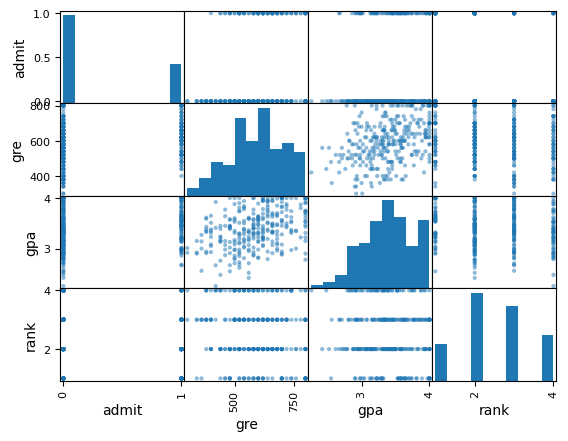

In [2]:
# create pairplot and get an overview of variable dependencies and distributions
pd.plotting.scatter_matrix(df_train);

## a)

Name the dependent variable and the independent variables.  
Which scales of measurement do the variables belong to? (e.g. nominal, ordinal, interval or ratio)

**Solution**

| Variable | Dependent?  | Scale of measurement |
| -------- | ----------- | --------------------- |
| *"rank"* | Independent | Ordinal               |
| *"gre"*  | Independent | Interval              |
| *"gpa"*  | Independent | Interval              |
| *"admit"*| Dependent   | Nominal               |

## b)

Use the statsmodels module and train a generalized linear model on the data from "admit-train.csv". 

In [4]:
import statsmodels.formula.api as smf

# Mark "rank" as categorical
df_train["rank"] = df_train["rank"].astype("category")

# Define and fit a model
logreg = smf.logit("admit ~ gre + gpa + rank", data=df_train)
result = logreg.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.547548
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  299
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            5
Date:                Thu, 14 Mar 2024   Pseudo R-squ.:                  0.1129
Time:                        02:00:44   Log-Likelihood:                -163.72
converged:                       True   LL-Null:                       -184.56
Covariance Type:            nonrobust   LLR p-value:                 6.846e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.8711      1.415     -3.444      0.001      -7.643      -2.099
rank[T.2]     -0.6255      0.

**Observation**: The categorical variable "rank" is represented by three different variables which indicate whether the rank has a certain value:
$$
rank[T.i] = \mathbb{I}[rank = i]
$$
For $rank = 1$, we don't need another variable since this case can be inferred if all other rank-variables are zero.

Which coefficients are statistically significant for a level of $\alpha=0.05$? 

**Solution**

For most attributes, the test-statistic $z$ has a p-value (``P > |z|``) which is below $\alpha$. We can conclude that these attributes are statistically significant at the given signifance level. Only for the attribute ``rank[T.2]``, we cannot reject the null hypothesis $H_0: \beta_{rank = 2} = 0$.

## c)

Interpret the coefficients.

**Solution**

| Parameter | Value | Interpretation |
| --- | --- | --- |
| intercept  | -4.8711 | - |
| $\beta_{gre}$ | 0.0031 | As the "gre" score increases by one point, the odds of being admitted increase by a factor of 1.003. ($\exp(0.003) \approx 1.003$) |
| $10 \cdot \beta_{gre}$ | 0.0301 | As the "gre" score increases by ten points, the odds of being admitted increase by a factor of 1.03. ($\exp(0.03) \approx 1.03$) |
| $\beta_{gpa}$ | 0.9204 | As the "gpa" score increases by one point, the odds of being admitted increase by a factor of 2.51. ($\exp(0.92) \approx 2.51$) |
| $\beta_{rank = 2}$ | -0.6255 | If the rank is 2, the odds of being accepted is lowered by a factor of 0.53 ($\exp(-0.63) \approx 0.53$) compared to rank 1. |
| $\beta_{rank = 3}$ | -1.5245 | If the rank is 3, the odds of being accepted is lowered by a factor of 0.22 ($\exp(-1.52) \approx 0.22$) compared to rank 1. |
| $\beta_{rank = 4}$ | -1.6853 | If the rank is 4, the odds of being accepted is lowered by a factor of 0.18 ($\exp(-1.69) \approx 0.18$) compared to rank 1. |

## d)

Test the significance of the attribute "rank" by using a Wald test. 

Is the attribute "rank" statistically significant w.r.t. a level of $\alpha = 5\%$?

In [5]:
# Specify the restrictions as a list of strings and pass it to "r_matrix"
wald_test_result = result.wald_test(
  	"(rank[T.2] = 0, rank[T.3] = 0, rank[T.4] = 0)", 
  	scalar=True
)
print(f"Test statistic (chi^2_{int(wald_test_result.df_denom)}-distributed): {wald_test_result.statistic}")
print(f"p-value of the statistic: {wald_test_result.pvalue}")

Test statistic (chi^2_3-distributed): 19.792977174387453
p-value of the statistic: 0.00018736312140189517


**Solution**

The attribute is statistically significant since $\text{p-value} < 5\%$.  
This means that we can reject the null-hypothesis ("$\beta_{\text{rank}}$ = 0") at a significance level of $\alpha = 5 \%$.

## e)

In order to gain a better understanding of the model, have a look at the predicted probabilities of some data points. Adjust only one parameter and keep the others constant. For example, keep "gre" and "gpa" constant (mean value), while varying "rank".

**Solution**

In [6]:
rank = [1, 2, 3, 4]
new_points = pd.DataFrame({"gre" : df_train["gre"].mean(),
                          "gpa" : df_train["gpa"].mean(),
                          "rank" : rank})

new_points["predictions"] = result.predict(new_points)

print(new_points)


          gre       gpa  rank  predictions
0  590.434783  3.386187     1     0.514788
1  590.434783  3.386187     2     0.362094
2  590.434783  3.386187     3     0.187661
3  590.434783  3.386187     4     0.164361


## f)

Find the McFadden ratio and interpret the results.

**Solution**

In [7]:
# McFadden Ratio
print(result.prsquared)

0.11291234609658529


## g)

Load the test data from *admit-test.csv* and predict the probability.

**Solution**

In [8]:
# load test data
df_test = pd.read_csv("admit-test.csv")

# assign proper data type
df_test["rank"] = df_test["rank"].astype("category")

# make predictions on test data
y_pred_test = (result.predict(df_test.drop(columns = ["admit"])) > 0.5).astype(int)

Construct the confusion matrix for the test data.

**Solution**

In [9]:
# build confusion matrix
y_true_test = df_test["admit"]
confusion_matrix = pd.crosstab(y_true_test, y_pred_test)
confusion_matrix

col_0,0,1
admit,,
0,58,8
1,26,9


## h)

Compute the accuracy 
$$
\frac{TP + TN}{TP + TN + FP + FN}
$$
of your trained model on the test set.

**Solution**

In [10]:
correct_predictions = (y_true_test == y_pred_test).sum()
total_predictions = len(y_true_test)
accuracy = correct_predictions / total_predictions

print("Accuracy =", "{:.3f}".format(accuracy))

Accuracy = 0.663
